# Finding negative number in list of integers

Task 2: Given a list of integer numbers, look for a negative number in the list. 

## The algorithm and its application

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute, IBMQ
from qiskit.visualization import plot_histogram
import math


# binary representation of integers (2's complement)
def int_to_binary_string(integer_list, num_bits):
    binary_str = bin(integer_list & int("1"*num_bits, 2))[2:].zfill(num_bits)
    return binary_str

# oracle using the binary representation
def oracle_circuit_binary(integer_list, num_bits):
    oc = QuantumCircuit(2)
    two_comp_bin_sign = [int_to_binary_string(integer,num_bits) for integer in integer_list]
    for i in two_comp_bin_sign:
        if i[0] == "1":
            oc.cz(0,1)
            break
    return oc

def grover_algorithm(oracle_circuit):
    # setting the number of qubits (from the Oracle)
    num_qubits = oracle_circuit.num_qubits
    num_iterations=int(math.pi/4*math.sqrt(num_qubits))

    grover_circuit = QuantumCircuit(num_qubits)
    
    # creating superposition of all states
    grover_circuit.h(range(num_qubits))
    
    for i in range(num_iterations):

        # oracle
        grover_circuit.append(oracle_circuit.to_instruction(), list(range(num_qubits)))

        # inversion about the average
        grover_circuit.h(range(num_qubits))
        grover_circuit.x(range(num_qubits))
        grover_circuit.h(num_qubits-1)
        grover_circuit.mcx(list(range(num_qubits-1)), num_qubits-1)
        grover_circuit.h(num_qubits-1)
        grover_circuit.x(range(num_qubits))
        grover_circuit.h(range(num_qubits))

    # measure the qubits
    grover_circuit.measure_all()

    return grover_circuit


# Create the Grover circuit with the oracle_binary
def find_negative_number(list_of_integers, num_bits): 
    grover_circuit = grover_algorithm(oracle_circuit_binary(list_of_integers, num_bits))

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    tqc = transpile(grover_circuit, simulator)
    result = simulator.run(tqc, shots=1000).result()

    # Display the results
    counts = result.get_counts(grover_circuit)
    if counts["11"]>900: 
        print(f"True (there is at least one negative integer in the list {list_of_integers})")
    else:
        print(f"False (no negative integer in the list {list_of_integers})")
    return counts

In [2]:

A = [-1,13,4,6,7]
find_negative_number(list_of_integers = A, num_bits = 8);
B = [1,13,4,6,7]
find_negative_number(list_of_integers = B, num_bits = 8);
C = [1,2,-3,-6,2,1,55]
find_negative_number(list_of_integers = C, num_bits = 8);

# in this case there is an overflow due to low bit number
D =  [1,2,3,6,2,1,128]
find_negative_number(list_of_integers = D, num_bits = 8);



True (there is at least one negative integer in the list [-1, 13, 4, 6, 7])
False (no negative integer in the list [1, 13, 4, 6, 7])
True (there is at least one negative integer in the list [1, 2, -3, -6, 2, 1, 55])
True (there is at least one negative integer in the list [1, 2, 3, 6, 2, 1, 128])


Above we can se that the circuit finds the negative numbers, however in case of D there is an overflow and the algorithm falseley detects a negative number. It is possible to have a bit number independent solution when we do not compute the binary representation at all only the signs. 

In [3]:
# sign representation only
def int_to_sign(integer_list):
    signs = []
    for integer in integer_list:
        if integer < 0:
            signs.append(1)
        else:
            signs.append(0)
    return signs

# oracle using the sign representation
def oracle_circuit_sign(integer_list):
    oc = QuantumCircuit(2)
    for i in int_to_sign(integer_list):
        if i == 1:
            oc.cz(0,1)
            break
    return oc

def find_negative_number_sign(list_of_integers): 
    grover_circuit = grover_algorithm(oracle_circuit_sign(list_of_integers))

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    tqc = transpile(grover_circuit, simulator)
    result = simulator.run(tqc, shots=1000).result()

    # Display the results
    counts = result.get_counts(grover_circuit)
    if counts["11"]>900: 
        print(f"True (there is at least one negative integer in the list {list_of_integers})")
    else:
        print(f"False (no negative integer in the list {list_of_integers})")
    return counts

In [4]:

A = [-1,13,4,6,7]
Neg = find_negative_number_sign(list_of_integers = A);
B = [1,13,4,6,7]
Pos = find_negative_number_sign(list_of_integers = B);
C = [1,2,-3,-6,2,1,55]
find_negative_number_sign(list_of_integers = C);

# in this case there the algorithm is not sensitive to the representation of the integers
D =  [1,2,3,6,2,1,128]
find_negative_number_sign(list_of_integers = D);

True (there is at least one negative integer in the list [-1, 13, 4, 6, 7])
False (no negative integer in the list [1, 13, 4, 6, 7])
True (there is at least one negative integer in the list [1, 2, -3, -6, 2, 1, 55])
False (no negative integer in the list [1, 2, 3, 6, 2, 1, 128])


## Plotting the measurement count histograms

For list with positive numbers

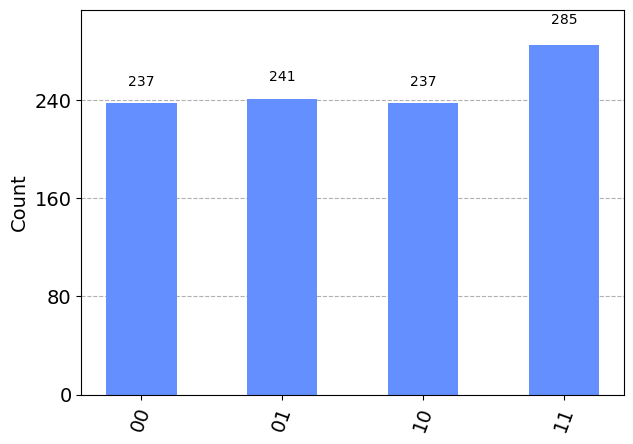

In [5]:
plot_histogram(Pos)

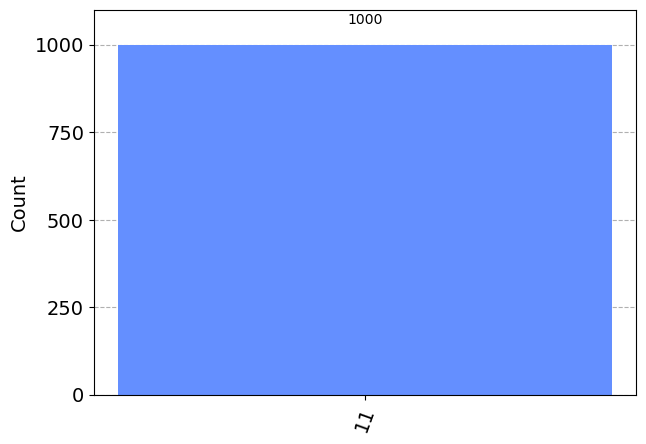

In [6]:
plot_histogram(Neg)

## Drawing the circuit

Here we draw the circuit with only one iteration of the Grover algorithm.

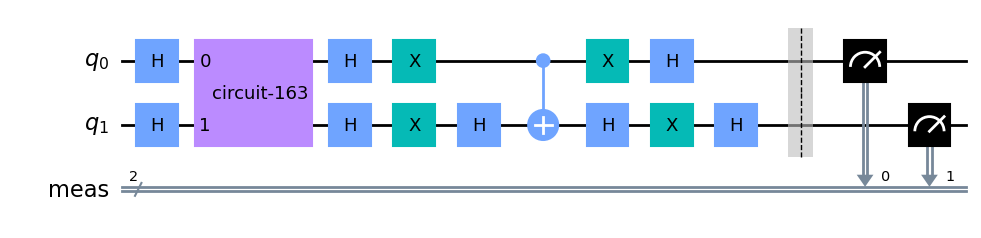

In [7]:
grover_algorithm(oracle_circuit_sign(A)).draw("mpl")

## Using a real quantum computer

In this section we execute the cicuit on a real quantum computer.

In [8]:
IBMQ.load_account()

C:\Users\uic53403\AppData\Local\Temp\ipykernel_18704\485379158.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
C:\Users\uic53403\AppData\Local\Temp\ipykernel_18704\485379158.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
provider = IBMQ.get_provider("ibm-q")

We look for a quantum computer backend

In [10]:
for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
    print(f"{backend.name()} : {backend.status().pending_jobs} & {qubit_count} qubits ")

ibmq_qasm_simulator : 0 & simulated qubits 
simulator_statevector : 0 & simulated qubits 
simulator_mps : 0 & simulated qubits 
simulator_extended_stabilizer : 0 & simulated qubits 
simulator_stabilizer : 0 & simulated qubits 
ibm_lagos : 38 & 7 qubits 
ibm_nairobi : 15 & 7 qubits 
ibm_perth : 5 & 7 qubits 
ibm_brisbane : 19 & 127 qubits 


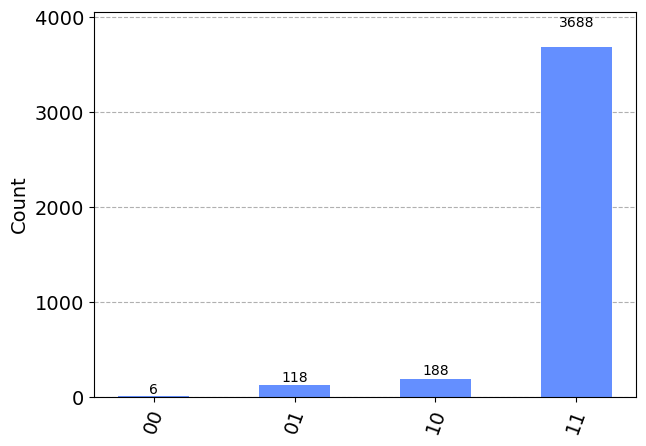

In [13]:
quantum_computer_backend = provider.get_backend("ibm_perth")
grover_circuit_q = grover_algorithm(oracle_circuit_sign([-1,2,3,4,5]))
job = execute(grover_circuit_q, backend = quantum_computer_backend)
plot_histogram(job.result().get_counts(grover_circuit_q))

As it was expected, quantum noise got into the measurements but with still hight probability the algorithm claims to find negative number in the list of integers.